In [1]:
# neccessary imports
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

## Load data
data = pd.read_csv('data/shipping_data.csv')
feature_names = data.columns.tolist()
target = 'Reached.on.Time_Y.N'  

In [2]:
# Quick overview of dataset
data.sample(5)

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
10607,10608,F,Ship,4,3,245,4,medium,F,5,4660,0
9812,9813,A,Ship,4,3,253,3,low,F,5,5703,0
5232,5233,D,Ship,3,3,259,3,medium,F,4,4259,0
8785,8786,F,Ship,3,1,151,3,low,F,7,4072,0
1795,1796,F,Flight,3,3,165,3,high,M,35,1459,1


In [3]:
print(f'Data shape: {data.shape[0]} rows & {data.shape[1]} columns \n')

pd.concat(
    [
    data[feature_names].dtypes,
    data[feature_names].nunique(),
    data[feature_names].count()
    ], keys=['dtypes', 'nunique', 'counts'], axis=1
)

Data shape: 10999 rows & 12 columns 



,dtypes,nunique,counts
ID,int64,10999,10999
Warehouse_block,object,5,10999
Mode_of_Shipment,object,3,10999
Customer_care_calls,int64,6,10999
Customer_rating,int64,5,10999
Cost_of_the_Product,int64,215,10999
Prior_purchases,int64,8,10999
Product_importance,object,3,10999
Gender,object,2,10999
Discount_offered,int64,65,10999


In [4]:
data.describe(include=np.number).T # Getting descriptive statistics of numerical features

,count,mean,std,min,25%,50%,75%,max
ID,10999.0,5500.000000,3175.282140,1.0,2750.5,5500.0,8249.5,10999.0
Customer_care_calls,10999.0,4.054459,1.141490,2.0,3.0,4.0,5.0,7.0
Customer_rating,10999.0,2.990545,1.413603,1.0,2.0,3.0,4.0,5.0
Cost_of_the_Product,10999.0,210.196836,48.063272,96.0,169.0,214.0,251.0,310.0
Prior_purchases,10999.0,3.567597,1.522860,2.0,3.0,3.0,4.0,10.0
Discount_offered,10999.0,13.373216,16.205527,1.0,4.0,7.0,10.0,65.0
Weight_in_gms,10999.0,3634.016729,1635.377251,1001.0,1839.5,4149.0,5050.0,7846.0
Reached.on.Time_Y.N,10999.0,0.596691,0.490584,0.0,0.0,1.0,1.0,1.0


In [5]:
data.describe(include=object).T # Getting descriptive statistics of categorical features

,count,unique,top,freq
Warehouse_block,10999,5,F,3666
Mode_of_Shipment,10999,3,Ship,7462
Product_importance,10999,3,low,5297
Gender,10999,2,F,5545


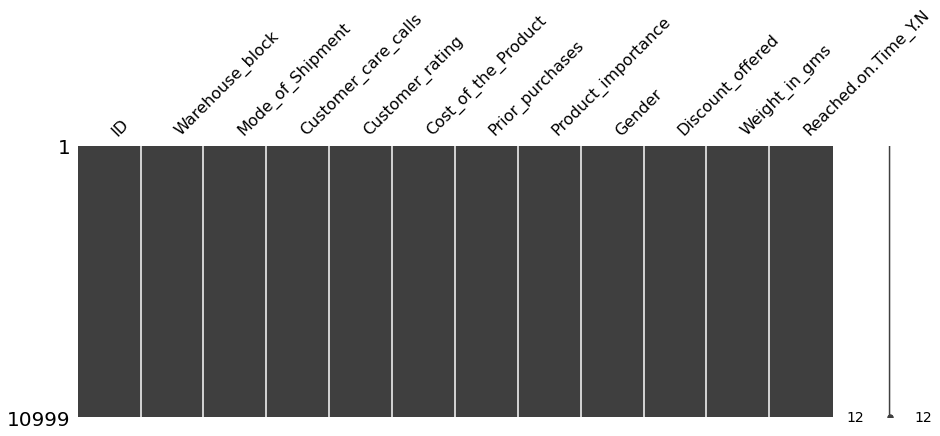

In [6]:
# Checking missing data instances
msno.matrix(data, figsize=(15,5));

In [7]:
# Dropping ID features as it has no-variation and contain all unique instances
feature_names.remove('ID')
data.drop(columns=['ID'], inplace=True)

# Splitting data into train and test
X = data.drop(columns=[target])
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=2022)

In [8]:
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()

4 categorical features 



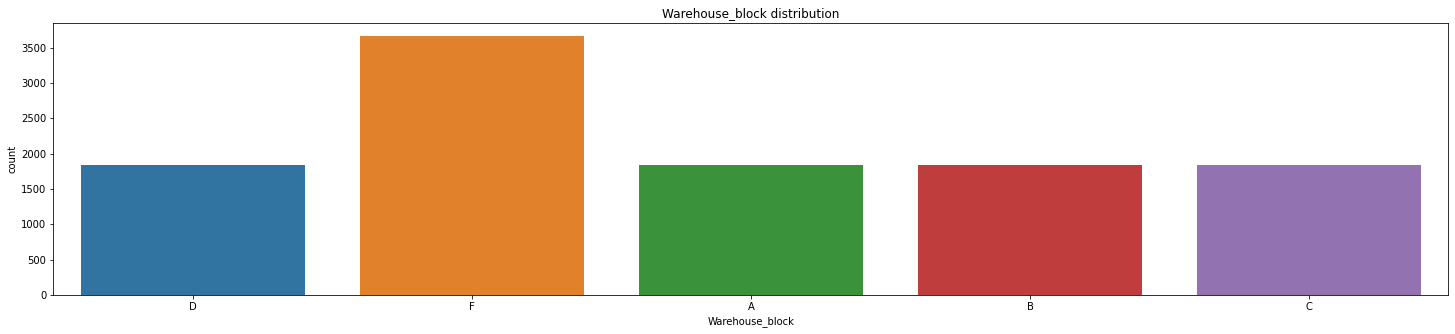

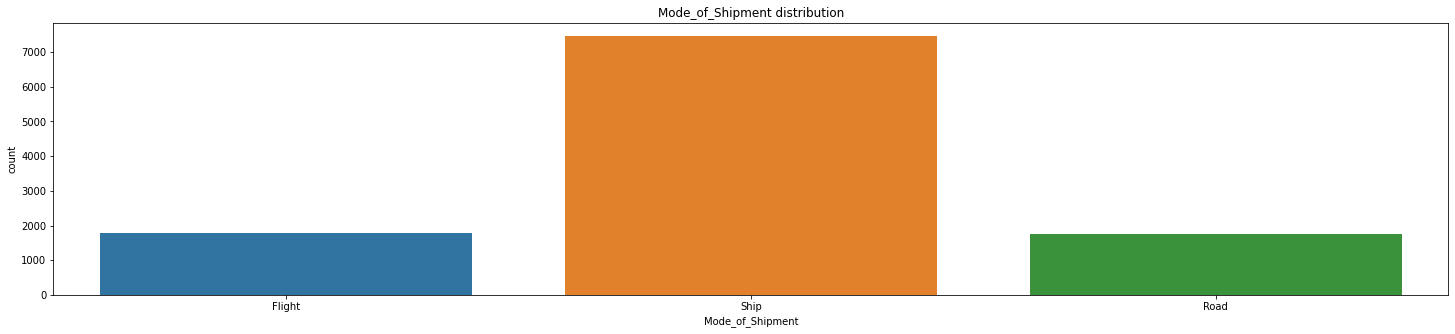

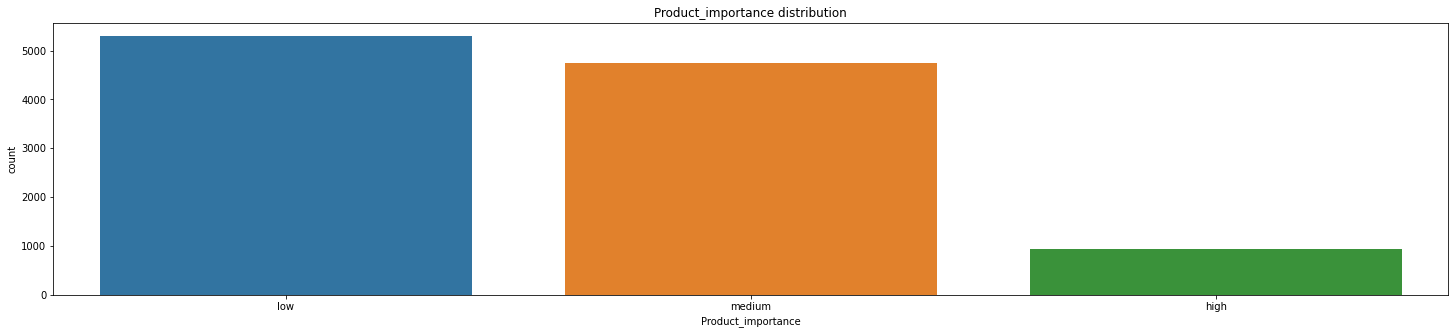

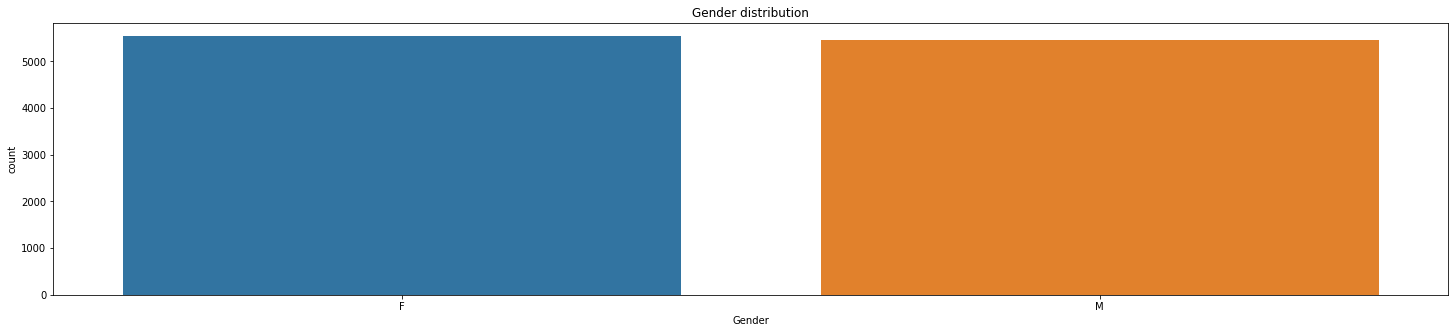

In [9]:
print(f'{len(categorical_features)} categorical features \n')
for col in categorical_features:
    plt.figure(figsize=(25,5))
    sns.countplot(x=col, data=data)
    plt.title(f"{col} distribution")
    plt.show()

In [10]:
## Re-categorical categories into nominal and ordinal categorical features
nominal_categroical_features = ['Mode_of_Shipment', 'Gender']
ordinal_categorical_features = ['Warehouse_block', 'Product_importance']

## Create preprocessing pipeline
numeric_pipeline = Pipeline(steps=[('scale', MinMaxScaler())])
warehouse_block_order = ['A', 'B', 'C', 'D', 'F']
product_importance_order = ['low', 'medium', 'high']
ordinal_categorical_pipeline = Pipeline(steps=[('ordinal encoding', OrdinalEncoder(categories=[warehouse_block_order, product_importance_order],handle_unknown="use_encoded_value", unknown_value=-1))])
nominal_categorical_pipeline = Pipeline(steps=[('one-hot encoding', OneHotEncoder(handle_unknown='ignore', sparse=False, drop='first'))])

## Compiling pipeline steps
preprocessing_pipeline = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('ordinal_category', ordinal_categorical_pipeline, ordinal_categorical_features),
    ('nominal_category', nominal_categorical_pipeline, nominal_categroical_features)])

## Compile model pipeline
xgboost_instance = XGBClassifier()
full_pipeline = Pipeline(steps=[
    ('preprocess', preprocessing_pipeline),
    ('model', xgboost_instance)])

_ = full_pipeline.fit(X_train, y_train)

In [11]:
_

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler())]),
                                                  ['Customer_care_calls',
                                                   'Customer_rating',
                                                   'Cost_of_the_Product',
                                                   'Prior_purchases',
                                                   'Discount_offered',
                                                   'Weight_in_gms']),
                                                 ('ordinal_category',
                                                  Pipeline(steps=[('ordinal '
                                                                   'encoding',
                                                                   OrdinalEncoder(categories=[['A',
                                                                                               'B',
                                                                                               'C',
                                                                                               'D',
                                                                                               'F'],
                                                                                              ['low',
                                                                                               'med...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_to_onehot=4, max_delta_step=0,
                               max_depth=6, max_leaves=0, min_child_weight=1,
                               missing=nan, monotone_constraints='()',
                               n_estimators=100, n_jobs=0, num_parallel_tree=1,
                               predictor='auto', random_state=0, reg_alpha=0,
                               reg_lambda=1, ...))])

In [12]:
# Making prediction
y_pred = full_pipeline.predict_proba(X_test)
# Evaluating results
print('ROC AUC score: ', roc_auc_score(y_test, y_pred[:, 1]))

ROC AUC score:  0.7386284220499958


In [13]:
# create an iterator object with write permission - pipeline.pkl
with open('../app/pipeline.pkl', 'wb') as file:
    pickle.dump(full_pipeline, file)